In [ ]:
# Colab에서 구동시 True로 설정하고 실행

Colab = False

In [ ]:
if Colab:
    from google.colab import drive

    drive.mount('/content/gdrive')

In [ ]:
# cd '/content/gdrive/MyDrive/Project_Methodology'

## MODULE

In [4]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

import warnings 
warnings.filterwarnings(action='ignore')

# -------------------------------------

import os
from tqdm import tqdm

import tensorflow as tf
from transformers import BertTokenizer, BertModel, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 데이터 불러오기

In [5]:
PATH = './data/'

In [6]:
data = pd.read_csv(PATH + "data.csv")

In [7]:
data.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63931 entries, 0 to 63930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      63931 non-null  object
 1   topic_idx  63931 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 999.0+ KB


## 데이터 처리

In [9]:
# train / test 분리
# DataFrame 특정 비율의 표본을 무작위로 추출 (fraction)

test_data = data.sample(frac=0.2, random_state=42)
train_data = data.drop(test_data.index)

print(f'test_data  : {len(test_data)}개\ntrain_data : {len(train_data)}개')


test_data  : 12786개
train_data : 51145개


In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [11]:
#random seed 고정
tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 32
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN = 44 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

Downloading: 100%|██████████| 996k/996k [00:02<00:00, 371kB/s]  
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 14.3kB/s]
Downloading: 100%|██████████| 625/625 [00:00<00:00, 313kB/s]


In [13]:
def bert_tokenizer(stc, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = stc,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids'] 
    
    return input_id, attention_mask, token_type_id

In [14]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["title"], train_data["topic_idx"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_input_ids), len(train_data_labels)))

100%|██████████| 51145/51145 [00:09<00:00, 5379.25it/s]


# sents: 51145, # labels: 51145


## 학습

In [15]:
# MODEL CLASS ------------------------------------------------------------------------------------------------------------------------------------
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

# ---------------------------------------------------------------------------------------------------------------------------------------------------

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=7)


Downloading: 100%|██████████| 1.08G/1.08G [02:13<00:00, 8.10MB/s]
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [97]:
model_name = "BERT_bert-base-multilingual-cased"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

data_out/KOR/BERT_bert-base-multilingual-cased -- Folder already exists 



In [98]:
history = cls_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
1279/1279 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.7862
Epoch 1: val_accuracy improved from -inf to 0.23961, saving model to data_out/KOR/BERT_bert-base-multilingual-cased/weights.h5
1279/1279 [==============================] - 538s 366ms/step - loss: 0.6116 - accuracy: 0.7862 - val_loss: 3.8708 - val_accuracy: 0.2396
Epoch 2/5
1279/1279 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8561
Epoch 2: val_accuracy improved from 0.23961 to 0.42497, saving model to data_out/KOR/BERT_bert-base-multilingual-cased/weights.h5
1279/1279 [==============================] - 469s 367ms/step - loss: 0.4083 - accuracy: 0.8561 - val_loss: 3.4518 - val_accuracy: 0.4250
Epoch 3/5
1279/1279 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8835
Epoch 3: val_accuracy did not improve from 0.42497
1279/1279 [==============================] - 462s 361ms/step - loss: 0.3295 - accuracy: 0.8835 - val_loss: 3.1530 - val_accurac

In [99]:
print(history.history)

{'loss': [0.6116100549697876, 0.4082953929901123, 0.32945170998573303, 0.265170693397522], 'accuracy': [0.7861716747283936, 0.8560709953308105, 0.8834930062294006, 0.9057581424713135], 'val_loss': [3.8707873821258545, 3.4517745971679688, 3.1529600620269775, 3.699690341949463], 'val_accuracy': [0.2396128624677658, 0.4249682128429413, 0.3252517282962799, 0.39583536982536316]}


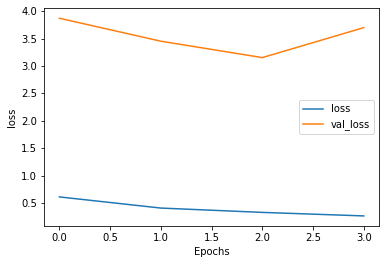

In [100]:
plot_graphs(history, 'loss')

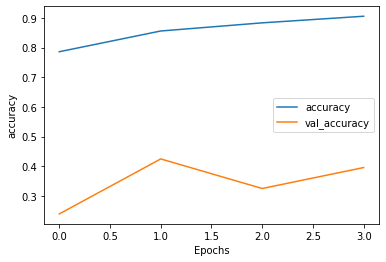

In [101]:
plot_graphs(history, 'accuracy')

In [102]:
# test_data
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent in tqdm(test_data["title"]): 
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)

100%|██████████| 12786/12786 [00:03<00:00, 3685.59it/s]


In [103]:
results = cls_model.predict(test_inputs, batch_size=1024)
results

array([[-2.6400237,  4.6861506, -1.256692 , ...,  2.8254995, -2.7031312,
        -3.6951356],
       [-2.9023147,  2.7016146,  3.2011623, ..., -3.4141357, -1.087383 ,
         1.0027833],
       [-2.9093654,  2.8371031,  0.6631102, ...,  1.305289 , -3.1373234,
        -0.2116031],
       ...,
       [-3.0413768,  6.8869753,  0.5513915, ..., -1.0986937, -3.8335135,
        -2.4693012],
       [-2.304958 ,  6.30997  , -1.8950852, ..., -1.3398821, -1.4648798,
        -3.5432305],
       [ 0.3452954,  4.8004065, -1.913462 , ..., -2.4594223, -1.5556952,
        -3.7462728]], dtype=float32)

In [104]:
topic = []
for i in range(len(results)):
    topic.append(np.argmax(results[i]))

topic

In [109]:
from sklearn.metrics import classification_report

report = classification_report(test_data['topic_idx'], topic)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.33      0.47      2128
           1       0.50      0.81      0.62      1881
           2       0.65      0.76      0.70      1473
           3       0.79      0.77      0.78      3000
           4       0.94      0.86      0.90      1552
           5       0.93      0.97      0.95      1383
           6       0.90      0.89      0.89      1369

    accuracy                           0.75     12786
   macro avg       0.79      0.77      0.76     12786
weighted avg       0.78      0.75      0.74     12786



In [107]:
DF = pd.DataFrame()

DF['original'] = test_data['topic_idx']
DF['predict'] = topic

DF

,original,predict
22458,1,1
11212,6,2
8618,6,1
52566,3,1
18473,3,3
...,...,...
32951,6,6
44658,3,3
39636,1,1
59520,0,1
